> Martin Fridrich 12/2024

# The final assignment

This Jupyter Notebook is designed to provide a solution for the honors project, which focuses on benchmarking various classification algorithms using a weather dataset. We will give a brief overview of the data and present a streamlined method for training and evaluating machine learning pipelines. Please note that while we did not utilize the [original notebook](https://raw.githubusercontent.com/fridrichmrtn/ibm-ai-engineering/refs/heads/main/01_machine_learning/final_assignment/original_assignment.ipynb), all project requirements will still be met.

### Table of contents

1. [Data loading](#data-loading)
2. [Data exploration](#data-exploration)
3. [Regression problem](#regression-problem)
4. [Classification problem](#classification-problem)

## Data loading

In [1]:
# download data if not exists
import os
import requests
import shutil
import pandas as pd

class DataUtils():
    def __init__(self,
                 data_url,
                 local_path):
        self.data_url = data_url
        self.local_path = local_path

    def _make_path(self):
        self.local_path_dir = os.path.dirname(self.local_path)
        os.makedirs(self.local_path_dir, exist_ok=True)

    def _download(self):
        if not os.path.exists(self.local_path):
            print("Source file not present, downloading...")
            try:
                response = requests.get(self.data_url)
                with open(self.local_path, "wb") as f:
                    f.write(response.content)
                print("Download successful.")
            except:
                print("Download unsuccessful.")
    
    def _load(self):
        print("Loading the source csv.")
        self.df = pd.read_csv(self.local_path)

    def _rm(self):
        shutil.rmtree(self.local_path_dir)

    def load(self):
        self._make_path()
        self._download()
        self._load()
        return self
        
du = DataUtils(data_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillUp/labs/ML-FinalAssignment/Weather_Data.csv",
          local_path="./data/weather_data.csv")

du.load()
du.df.head()

Loading the source csv.


,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2/1/2008,19.5,22.4,15.6,6.2,0.0,W,41,S,SSW,...,92,84,1017.6,1017.4,8,8,20.7,20.9,Yes,Yes
1,2/2/2008,19.5,25.6,6.0,3.4,2.7,W,41,W,E,...,83,73,1017.9,1016.4,7,7,22.4,24.8,Yes,Yes
2,2/3/2008,21.6,24.5,6.6,2.4,0.1,W,41,ESE,ESE,...,88,86,1016.7,1015.6,7,8,23.5,23.0,Yes,Yes
3,2/4/2008,20.2,22.8,18.8,2.2,0.0,W,41,NNE,E,...,83,90,1014.2,1011.8,8,8,21.4,20.9,Yes,Yes
4,2/5/2008,19.7,25.7,77.4,4.8,0.0,W,41,NNE,W,...,88,74,1008.3,1004.8,8,8,22.5,25.5,Yes,Yes


## Data exploration

In [2]:
df = du.df.copy()
df.info()
del du

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3271 entries, 0 to 3270
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3271 non-null   object 
 1   MinTemp        3271 non-null   float64
 2   MaxTemp        3271 non-null   float64
 3   Rainfall       3271 non-null   float64
 4   Evaporation    3271 non-null   float64
 5   Sunshine       3271 non-null   float64
 6   WindGustDir    3271 non-null   object 
 7   WindGustSpeed  3271 non-null   int64  
 8   WindDir9am     3271 non-null   object 
 9   WindDir3pm     3271 non-null   object 
 10  WindSpeed9am   3271 non-null   int64  
 11  WindSpeed3pm   3271 non-null   int64  
 12  Humidity9am    3271 non-null   int64  
 13  Humidity3pm    3271 non-null   int64  
 14  Pressure9am    3271 non-null   float64
 15  Pressure3pm    3271 non-null   float64
 16  Cloud9am       3271 non-null   int64  
 17  Cloud3pm       3271 non-null   int64  
 18  Temp9am 

In [3]:
# fix dates
df["Date"] = pd.to_datetime(df.Date)
df["Year"] = df.Date.dt.year
df["Month"] = df.Date.dt.month
df.drop(columns=["Date"], inplace=True)

# fix target
df["RainTomorrow"] = df["RainTomorrow"].map({"Yes":1,"No":0})

We broke down the `Date` feature into its components based on the estimated data types and removed the original column. Additionally, we created a binary representation of the target variable, `RainTomorrow.`

For further analysis, we applied one-hot encoding using a `Pipeline.` We also printed summary statistics for the features and examined the correlations between features and the target for further investigation.

In [4]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

target = "RainTomorrow"
cat_features = ["RainToday", "WindGustDir", "WindDir9am", "WindDir3pm"]
num_features = [ c for c in df.columns if c not in [target]+cat_features]
features = cat_features+num_features

pipe = Pipeline([
    ("features",
        ColumnTransformer([
            ("numerical", "passthrough", num_features),
            ("categorical", OneHotEncoder(), cat_features)
        ])),
    ])

transformed_df = pipe.fit_transform(df[features], df[target])
transformed_df = pd.DataFrame(transformed_df, columns=pipe.get_feature_names_out())
transformed_df[target] = df[target]
transformed_df.head()

,numerical__MinTemp,numerical__MaxTemp,numerical__Rainfall,numerical__Evaporation,numerical__Sunshine,numerical__WindGustSpeed,numerical__WindSpeed9am,numerical__WindSpeed3pm,numerical__Humidity9am,numerical__Humidity3pm,...,categorical__WindDir3pm_NW,categorical__WindDir3pm_S,categorical__WindDir3pm_SE,categorical__WindDir3pm_SSE,categorical__WindDir3pm_SSW,categorical__WindDir3pm_SW,categorical__WindDir3pm_W,categorical__WindDir3pm_WNW,categorical__WindDir3pm_WSW,RainTomorrow
0,19.5,22.4,15.6,6.2,0.0,41.0,17.0,20.0,92.0,84.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,19.5,25.6,6.0,3.4,2.7,41.0,9.0,13.0,83.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,21.6,24.5,6.6,2.4,0.1,41.0,17.0,2.0,88.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,20.2,22.8,18.8,2.2,0.0,41.0,22.0,20.0,83.0,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,19.7,25.7,77.4,4.8,0.0,41.0,11.0,6.0,88.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [5]:
transformed_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
numerical__MinTemp,3271.0,14.877102,4.554710,4.3,11.00,14.9,18.8,27.6
numerical__MaxTemp,3271.0,23.005564,4.483752,11.7,19.60,22.8,26.0,45.8
numerical__Rainfall,3271.0,3.342158,9.917746,0.0,0.00,0.0,1.4,119.4
numerical__Evaporation,3271.0,5.175787,2.757684,0.0,3.20,4.8,7.0,18.4
numerical__Sunshine,3271.0,7.168970,3.815966,0.0,4.25,8.3,10.2,13.6
...,...,...,...,...,...,...,...,...
categorical__WindDir3pm_SW,3271.0,0.012534,0.111270,0.0,0.00,0.0,0.0,1.0
categorical__WindDir3pm_W,3271.0,0.061449,0.240189,0.0,0.00,0.0,0.0,1.0
categorical__WindDir3pm_WNW,3271.0,0.055946,0.229853,0.0,0.00,0.0,0.0,1.0
categorical__WindDir3pm_WSW,3271.0,0.033935,0.181089,0.0,0.00,0.0,0.0,1.0


In [6]:
# the most positively correlated features
transformed_df.corr()[target].sort_values(ascending=False).head(10)

RainTomorrow                   1.000000
numerical__Humidity3pm         0.477580
numerical__Cloud3pm            0.415801
categorical__RainToday_Yes     0.346207
numerical__Cloud9am            0.338545
numerical__Humidity9am         0.335966
numerical__Rainfall            0.296120
categorical__WindDir3pm_SSW    0.171661
numerical__WindGustSpeed       0.145382
categorical__WindDir3pm_S      0.141494
Name: RainTomorrow, dtype: float64

In [7]:
# the most negatively correlated features
transformed_df.corr()[target].sort_values(ascending=True).head(10)

numerical__Sunshine            -0.529112
categorical__RainToday_No      -0.346207
numerical__Temp3pm             -0.190583
numerical__MaxTemp             -0.152525
categorical__WindDir3pm_E      -0.106425
categorical__WindDir9am_W      -0.104663
categorical__WindDir3pm_WNW    -0.095579
categorical__WindDir3pm_ENE    -0.092706
categorical__WindGustDir_ENE   -0.091783
categorical__WindDir9am_WNW    -0.084153
Name: RainTomorrow, dtype: float64

The printouts and pair plots show that rain is more likely tomorrow with higher humidity and cloudy weather. If it is sunnier today and there is no rain, there is a lower chance of rain tomorrow.

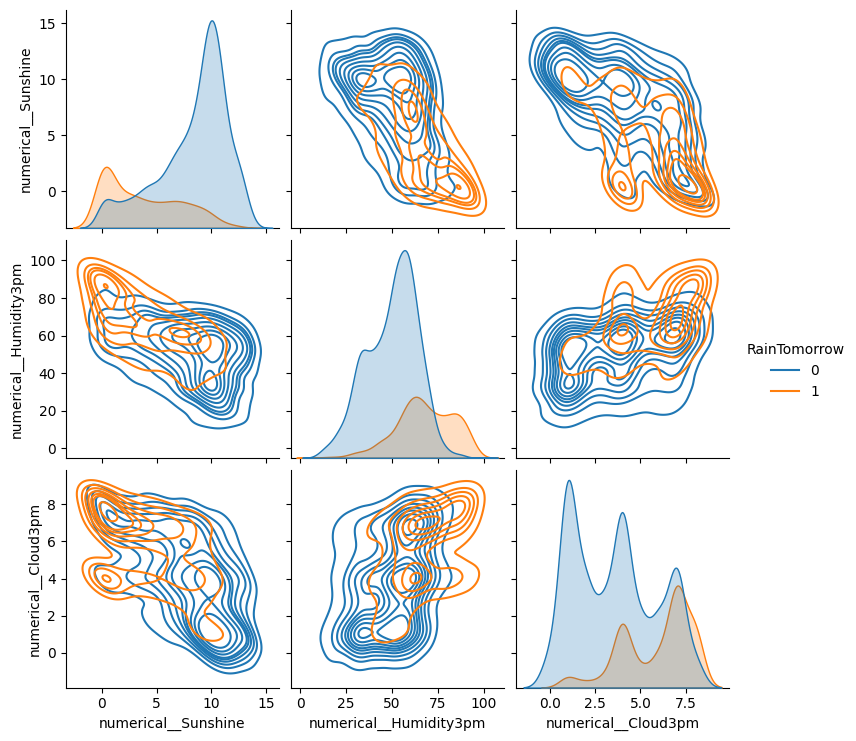

In [8]:
# seaborn pairs plot
from seaborn import pairplot

pairplot(transformed_df.loc[:,["numerical__Sunshine", "numerical__Humidity3pm",
                                "numerical__Cloud3pm", "RainTomorrow"]],
            hue="RainTomorrow", kind="kde")
del pipe, transformed_df

## Regression problem

To train and evaluate the linear regression model on both the training and test sets, we developed a solution that avoids code repetition for data splitting and evaluation. We implemented transformation and modeling steps using the `Pipeline` object. In this process, we applied `MinMaxScaler` and `OneHotEncoder` to ensure that all independent variables are scaled to the same range.

In [9]:
from sklearn.model_selection import train_test_split

def get_data_dict(data, target, features, test_size, random_state):
    # data split
    X_train, X_test, y_train, y_test = train_test_split(
        data[features], data[target], test_size=test_size, random_state=random_state)

    return {"train":{
                "X":X_train,
                "y":y_train},
            "test":{
                "X":X_test,
                "y":y_test}}

# data definition
target = "RainTomorrow"
cat_features = ["RainToday", "WindGustDir", "WindDir9am", "WindDir3pm"]
num_features = [c for c in df.columns if c not in [target]+cat_features]
features = cat_features+num_features
data = get_data_dict(df, target, features, 0.2, 10)

print(f"Ex. of five categorical features {cat_features[:5]}.")
print(f"Ex. of five numerical features {num_features[:5]}.")
print(f"Target is {target}.")

Ex. of five categorical features ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm'].
Ex. of five numerical features ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine'].
Target is RainTomorrow.


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# pipeline
pipe = Pipeline([
    ("feats",
        ColumnTransformer([
            ("numerical", MinMaxScaler(), num_features),
            ("categorical", OneHotEncoder(), cat_features)
        ])),
    ("lr",
        LinearRegression())
    ])

# training
pipe.fit(data["train"]["X"], data["train"]["y"])

Pipeline(steps=[('feats',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm', 'Year',
                                                   'Month']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['RainToday', 'WindGustDir',
                                                   'WindDir9am',
                                                   'WindDir3pm'])])),
                ('lr', LinearRegression())])

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def get_regression_report(pipe, data,
                          metrics=[mean_absolute_error, mean_squared_error, r2_score]):
    report_ls = []
    for set_name, set_dict in data.items():
        predicted = pipe.predict(set_dict["X"])
        report_ls.append(
            pd.DataFrame(
                [{f.__name__:f(set_dict["y"], predicted) for f in metrics}],
                index=[set_name]))
    return pd.concat(report_ls)

# see the results
get_regression_report(pipe, data)

,mean_absolute_error,mean_squared_error,r2_score
train,0.256919,0.116225,0.386950
test,0.256226,0.115708,0.427195


The report indicates that the model is not performing very well, even though it captures some aspects of the relationship. We are unclear on the reasoning behind using a regression model for a classification task in this project.

## Classification problem

To train and evaluate the classification models on both the training and test sets, we created a solution that minimizes code repetition for data splitting, modeling, and evaluation. We utilized the `Pipeline` object to implement the transformation and modeling steps. Additionally, we simplified the evaluation reporting process to ensure it can be reused for all models.

In [12]:
# get data
data = get_data_dict(df, target, features, 0.2, 1)

print(f"Ex. of five categorical features {cat_features[:5]}.")
print(f"Ex. of five numerical features {num_features[:5]}.")
print(f"Target is {target}.")

Ex. of five categorical features ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm'].
Ex. of five numerical features ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine'].
Target is RainTomorrow.


In [13]:
# define classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

classifiers  = {"knn":KNeighborsClassifier(n_neighbors=4),
        "dt":DecisionTreeClassifier(),
        "lr":LogisticRegression(solver="liblinear"),
        "svm":SVC(C=5,probability=True)}

# define and fit pipes
pipes = {name:
         Pipeline([
            ("feats",
                ColumnTransformer([
                    ("numerical", MinMaxScaler(), num_features),
                    ("categorical", OneHotEncoder(), cat_features)])),
            ("clf", clf)]).fit(data["train"]["X"], data["train"]["y"])
         for name, clf in classifiers.items()}

pipes["lr"]

Pipeline(steps=[('feats',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm', 'Year',
                                                   'Month']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['RainToday', 'WindGustDir',
                                                   'WindDir9am',
                                                   'WindDir3pm'])])),
                ('clf', LogisticRegression(solver='liblinear'))])

In [14]:
from sklearn.metrics import jaccard_score, accuracy_score, f1_score, log_loss

def get_classification_report(pipes, data,
                              metrics=[accuracy_score, jaccard_score, f1_score, log_loss]):
    
    result_ls = []    
    for pipe_name, pipe_object in pipes.items():
        for set_name, set_dict in data.items():
            predicted_class = pipe_object.predict(set_dict["X"])
            predicted_proba = pipe_object.predict_proba(set_dict["X"])[:,-1]
            temp_dict = {}
            for f in metrics:
                if f.__name__!="log_loss":
                    f_val = f(set_dict["y"], predicted_class)
                else:
                    f_val = f(set_dict["y"], predicted_proba)
                temp_dict[f.__name__] = f_val
            temp_dict["clf"] = pipe_name
            temp_dict["set"] = set_name        
            result_ls.append(temp_dict)

    return pd.DataFrame(result_ls).reset_index(drop=True)\
        .loc[:,["clf", "set", "accuracy_score", "jaccard_score", "f1_score", "log_loss"]]

get_classification_report(pipes, data)

,clf,set,accuracy_score,jaccard_score,f1_score,log_loss
0,knn,train,0.844037,0.428571,0.600000,2.781426e-01
1,knn,test,0.784733,0.318841,0.483516,2.435080e+00
2,dt,train,1.000000,1.000000,1.000000,2.220446e-16
3,dt,test,0.781679,0.406639,0.578171,7.869072e+00
4,lr,train,0.841361,0.482544,0.650967,3.531167e-01
5,lr,test,0.824427,0.479638,0.648318,3.838035e-01
6,svm,train,0.920489,0.707865,0.828947,2.463683e-01
7,svm,test,0.839695,0.516129,0.680851,3.793581e-01


The report indicates that svm and logistic regression achieved the best performance on the test set across all metrics, while knn exhibited the poorest performance. The significant disparity between the decision tree classifier's performance on the training and test sets suggests that it is overfitted. This issue might be addressed by adjusting the hyperparameters appropriately.

> Martin Fridrich 12/2024